# Import Libraries

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

# For implementing pipeline
from sklearn.pipeline import Pipeline


# For Scaling the data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# For Classification
from sklearn.neighbors import KNeighborsClassifier

# For Splitting the data for training and Validation
from sklearn.model_selection import train_test_split

# For creating model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Principal Component Analysis for Dimensionality Reduction
from sklearn.decomposition import PCA

# For Shuffling the DataFrame
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Take a look to the data
df = pd.read_csv("../Dataset/train.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Exploratory Data Analysis

In [3]:
# take a look to features property
missing = []
unique = []
types = []
variables = []
count = []

for item in df.columns:
    variables.append(item)
    missing.append(df[item].isnull().sum())
    unique.append(df[item].nunique())
    types.append(df[item].dtypes)
    count.append(len(df[item]))
    
output = pd.DataFrame({
    'variable': variables, 
    'dtype': types,
    'count': count,
    'unique': unique,
    'missing': missing, 
   
})   
output.sort_values("missing",ascending=False).reset_index(drop=True)

,variable,dtype,count,unique,missing
0,Credit_History,float64,614,2,50
1,Self_Employed,object,614,2,32
2,LoanAmount,float64,614,203,22
3,Dependents,object,614,4,15
4,Loan_Amount_Term,float64,614,10,14
5,Gender,object,614,2,13
6,Married,object,614,2,3
7,Loan_ID,object,614,614,0
8,Education,object,614,2,0
9,ApplicantIncome,int64,614,505,0


In [4]:
# As we can see from the table above, the Credit_History have unique values of 2. Which is 1 or 0.
# We will change it to an object
df['Credit_History'] = df['Credit_History'].astype('O')

In [5]:
# Describe the numerical data
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,592.000000,600.00000
mean,5403.459283,1621.245798,146.412162,342.00000
std,6109.041673,2926.248369,85.587325,65.12041
min,150.000000,0.000000,9.000000,12.00000
25%,2877.500000,0.000000,100.000000,360.00000
50%,3812.500000,1188.500000,128.000000,360.00000
75%,5795.000000,2297.250000,168.000000,360.00000
max,81000.000000,41667.000000,700.000000,480.00000


In [6]:
# describe categorical data ("object")

df.describe(include='O')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status
count,614,601,611,599,614,582,564.0,614,614
unique,614,2,2,4,2,2,2.0,3,2
top,LP001002,Male,Yes,0,Graduate,No,1.0,Semiurban,Y
freq,1,489,398,345,480,500,475.0,233,422


The percentage of Y class :  0.6872964169381107
The percentage of N class :  0.3127035830618892


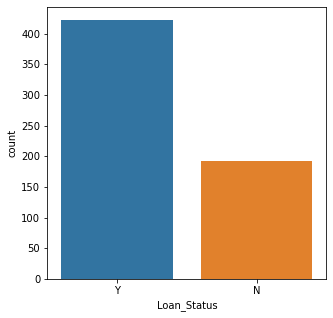

In [7]:
# Let's see if the dataset is imbalanced or not based on the target of prediction which is Loan_Status

plt.figure(figsize=(5,5))
sns.countplot(x= df['Loan_Status'],data = df)

print('The percentage of Y class : ' , (df['Loan_Status'].value_counts()[0] / len(df)))
print('The percentage of N class : ' , (df['Loan_Status'].value_counts()[1] / len(df)))

In [8]:
# it does look imbalanced, there are few method that can be used.


### Let's take a look for each feature in our dataset

#### 1. Loan_ID

In [9]:
print(df['Loan_ID'].describe())
print("Number of null values : ", df['Loan_ID'].isnull().sum())

count          614
unique         614
top       LP001002
freq             1
Name: Loan_ID, dtype: object
Number of null values :  0


Each of Loan taken individual have their own indiviudal Loan_ID. In fact this column not going impact to our training model prediction so we can drop it

#### 2. Gender

In [10]:
print(df['Gender'].describe())
print("Number of null values : ", df['Gender'].isnull().sum())
print(df['Gender'].value_counts())

count      601
unique       2
top       Male
freq       489
Name: Gender, dtype: object
Number of null values :  13
Male      489
Female    112
Name: Gender, dtype: int64


What values that should be filled in the null? There are few ways to do so, but I will use model predictions to determine which values should be filled.

`The question is which features that will be used?`

In [11]:
# Let's check the null value row and see which features that can be used. 
# If there are a lot of rows using sampling techniques or show it in countplot
samples_with_null_values_on_gender_column = df[df['Gender'].isnull()]
samples_with_null_values_on_gender_column

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
23,LP001050,NaN,Yes,2,Not Graduate,No,3365,1917.0,112.0,360.0,0.0,Rural,N
126,LP001448,NaN,Yes,3+,Graduate,No,23803,0.0,370.0,360.0,1.0,Rural,Y
171,LP001585,NaN,Yes,3+,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y
188,LP001644,NaN,Yes,0,Graduate,Yes,674,5296.0,168.0,360.0,1.0,Rural,Y
314,LP002024,NaN,Yes,0,Graduate,No,2473,1843.0,159.0,360.0,1.0,Rural,N
334,LP002103,NaN,Yes,1,Graduate,Yes,9833,1833.0,182.0,180.0,1.0,Urban,Y
460,LP002478,NaN,Yes,0,Graduate,Yes,2083,4083.0,160.0,360.0,NaN,Semiurban,Y
467,LP002501,NaN,Yes,0,Graduate,No,16692,0.0,110.0,360.0,1.0,Semiurban,Y
477,LP002530,NaN,Yes,2,Graduate,No,2873,1872.0,132.0,360.0,0.0,Semiurban,N
507,LP002625,NaN,No,0,Graduate,No,3583,0.0,96.0,360.0,1.0,Urban,N


- Most of these people are married. So we can't fill Gender based on `Married` column.
- Most of these people are graduated. So we can't fill Gender based on `Education` column.
- Most of these people are self employed. So we can't fill Gender based on `Self_Employed` column.
- Most of these people are having `Credit_History` and `Loan_Amount_Term` as 360 days(1 year).
- Since we are going to predict applicant's Gender, we can omit CoapplicantIncome
- So we are going predict the Gender based on `Dependents`, `ApplicantIncome`, `LoanAmount`, and `Property_Area`

In [12]:
# I will be used KNN Classifer
# Initialize Gender predictor columns list
GENDER_PREDICTOR_COLUMNS = ['Dependents', 'ApplicantIncome', 'LoanAmount', 'Property_Area', 'Gender']

samples_gender = df.copy()

#Convert categorical data to numerical data
encode = LabelEncoder()
samples_gender['Dependents'] = encode.fit_transform(samples_gender['Dependents'])
samples_gender['Property_Area'] = encode.fit_transform(samples_gender['Property_Area'])


# Let's get the rows not having null values on gender column
samples_without_null_values_on_gender_column = samples_gender[~samples_gender['Gender'].isnull()][GENDER_PREDICTOR_COLUMNS]
# Dropping samples having null values in predictor columns
samples_without_null_values_on_gender_column = samples_without_null_values_on_gender_column.dropna(how = 'any')
#Will be used as train data


# Building Gender Predictor using Pipeline and KNeigborsClassifiers
Gender_predictor = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('gen_predictor', KNeighborsClassifier(n_neighbors = 2))
])
Gender_predictor.fit(samples_without_null_values_on_gender_column.iloc[:, :-1].values,
                    samples_without_null_values_on_gender_column.iloc[:, -1].values)



Pipeline(steps=[('scaler', StandardScaler()),
                ('gen_predictor', KNeighborsClassifier(n_neighbors=2))])

In [13]:
#Fill the null values with predicted values from knn model
for row in range(samples_gender.shape[0]):
    if(samples_gender.loc[row,'Gender'] is np.nan):
        X = samples_gender.loc[row, GENDER_PREDICTOR_COLUMNS[:-1]].values.reshape(1, -1)
        df.loc[row,'Gender'] = Gender_predictor.predict(X)
      

In [14]:
df['Gender'].isnull().sum()

0

In [15]:
df['Gender'] = encode.fit_transform(df['Gender'])

#### 3. Married

In [16]:
# TODO : Describing Married column
print(df['Married'].describe())
print("Number of null values : ", df['Married'].isnull().sum())
print(df['Married'].value_counts())

count     611
unique      2
top       Yes
freq      398
Name: Married, dtype: object
Number of null values :  3
Yes    398
No     213
Name: Married, dtype: int64


In [17]:
df[df['Married'].isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
104,LP001357,1,NaN,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
228,LP001760,1,NaN,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
435,LP002393,0,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


As we can see there are `Graduate`, `No Self_Employed`       

In [18]:
# Lets see what Married people will be look like
df[df['Married'] == 'Yes'].describe(include = 'all')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,398,398.000000,398,390,398,380,398.000000,398.000000,384.000000,389.000000,362.0,398,398
unique,398,NaN,1,4,2,2,NaN,NaN,NaN,NaN,2.0,3,2
top,LP001003,NaN,Yes,0,Graduate,No,NaN,NaN,NaN,NaN,1.0,Semiurban,Y
freq,1,NaN,398,174,309,326,NaN,NaN,NaN,NaN,305.0,151,285
mean,NaN,0.917085,NaN,NaN,NaN,NaN,5629.173367,1794.632965,155.750000,336.987147,NaN,NaN,NaN
std,NaN,0.276100,NaN,NaN,NaN,NaN,6989.254425,2039.962354,89.934267,66.739163,NaN,NaN,NaN
min,NaN,0.000000,NaN,NaN,NaN,NaN,150.000000,0.000000,17.000000,12.000000,NaN,NaN,NaN
25%,NaN,1.000000,NaN,NaN,NaN,NaN,2817.500000,0.000000,108.000000,360.000000,NaN,NaN,NaN
50%,NaN,1.000000,NaN,NaN,NaN,NaN,3854.500000,1625.000000,132.000000,360.000000,NaN,NaN,NaN
75%,NaN,1.000000,NaN,NaN,NaN,NaN,5820.500000,2464.000000,178.500000,360.000000,NaN,NaN,NaN


- There are 398 married applicants, among them 309 are Graduated, 326 are Not Self_Employed, 151 semi-urban.
- Applicant Income and Co Appliant Income are most similar
- From this, we can assume that all missing samples as Married.


In [19]:
df[df['Married'] == 'No'].describe(include = 'all')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,213,213.000000,213,209,213,199,213.000000,213.000000,206.000000,208.000000,199.0,213,213
unique,213,NaN,1,4,2,2,NaN,NaN,NaN,NaN,2.0,3,2
top,LP001002,NaN,No,0,Graduate,No,NaN,NaN,NaN,NaN,1.0,Semiurban,Y
freq,1,NaN,213,171,168,171,NaN,NaN,NaN,NaN,167.0,80,134
mean,NaN,0.624413,NaN,NaN,NaN,NaN,4970.384977,1316.558685,128.883495,351.115385,NaN,NaN,NaN
std,NaN,0.485415,NaN,NaN,NaN,NaN,4004.332801,4097.418521,74.385981,60.398565,NaN,NaN,NaN
min,NaN,0.000000,NaN,NaN,NaN,NaN,416.000000,0.000000,9.000000,36.000000,NaN,NaN,NaN
25%,NaN,0.000000,NaN,NaN,NaN,NaN,2917.000000,0.000000,88.000000,360.000000,NaN,NaN,NaN
50%,NaN,1.000000,NaN,NaN,NaN,NaN,3750.000000,0.000000,115.500000,360.000000,NaN,NaN,NaN
75%,NaN,1.000000,NaN,NaN,NaN,NaN,5417.000000,1783.000000,144.750000,360.000000,NaN,NaN,NaN


In [20]:
df['Married'] = df['Married'].fillna('Yes')
# TODO : encoding categorical values into numerical values
df['Married'] = df['Married'].apply(lambda x : {'Yes' : 1, 'No' : 0}[x])

In [21]:
df['Married'].isnull().sum()

0

#### 4 .Education

In [22]:
# TODO : Descriptive Statistics on EDucation columns
print(df['Education'].describe())
print(df['Education'].isnull().sum())
print(df['Education'].value_counts())

count          614
unique           2
top       Graduate
freq           480
Name: Education, dtype: object
0
Graduate        480
Not Graduate    134
Name: Education, dtype: int64


In [23]:
# TODO : Encoding categorical data into Numerical data
df['Education'] = df['Education'].apply(lambda x : {'Graduate' : 1, 'Not Graduate' : 0}[x])

#### 5.Dependants

In [24]:
print(df['Dependents'].describe())
print("Number of null values : ", df['Dependents'].isnull().sum())
print("Unique values : ", df['Dependents'].unique())
print("Value counts : \n", df['Dependents'].value_counts())

count     599
unique      4
top         0
freq      345
Name: Dependents, dtype: object
Number of null values :  15
Unique values :  ['0' '1' '2' '3+' nan]
Value counts : 
 0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64


In [25]:
df[df['Dependents'].isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
102,LP001350,1,1,NaN,1,No,13650,0.0,NaN,360.0,1.0,Urban,Y
104,LP001357,1,1,NaN,1,No,3816,754.0,160.0,360.0,1.0,Urban,Y
120,LP001426,1,1,NaN,1,No,5667,2667.0,180.0,360.0,1.0,Rural,Y
226,LP001754,1,1,NaN,0,Yes,4735,0.0,138.0,360.0,1.0,Urban,N
228,LP001760,1,1,NaN,1,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
293,LP001945,0,0,NaN,1,No,5417,0.0,143.0,480.0,0.0,Urban,N
301,LP001972,1,1,NaN,0,No,2875,1750.0,105.0,360.0,1.0,Semiurban,Y
332,LP002100,1,0,NaN,1,No,2833,0.0,71.0,360.0,1.0,Urban,Y
335,LP002106,1,1,NaN,1,Yes,5503,4490.0,70.0,NaN,1.0,Semiurban,Y
346,LP002130,1,1,NaN,0,No,3523,3230.0,152.0,360.0,0.0,Rural,N


In [26]:
# Most of them are married. So we can fill the null values on Dependents column based on Married column
for row in range(df.shape[0]):
    if df.loc[row, 'Dependents'] is np.nan:
        df.loc[row, 'Dependents'] = str(df.loc[row, 'Married'])
# TODO : Encoding Categorical data into NUmerical Data
df['Dependents'] = df['Dependents'].apply(lambda x : {'0' : 0, '1' : 1, '2' : 2, '3+' : 3}[x])

#### 6. Self_Employed

In [27]:
print(df['Self_Employed'].describe())
print("Number of null values : ", df['Self_Employed'].isnull().sum())
print("Unique values : ", df['Self_Employed'].unique())
print("Value counts : \n", df['Self_Employed'].value_counts())

count     582
unique      2
top        No
freq      500
Name: Self_Employed, dtype: object
Number of null values :  32
Unique values :  ['No' 'Yes' nan]
Value counts : 
 No     500
Yes     82
Name: Self_Employed, dtype: int64


In [28]:
print(df[df['Self_Employed'].isnull()])
print(df[df['Self_Employed'].isnull()]['Education'].value_counts())

      Loan_ID  Gender  Married  Dependents  Education Self_Employed  \
11   LP001027       1        1           2          1           NaN   
19   LP001041       1        1           0          1           NaN   
24   LP001052       1        1           1          1           NaN   
29   LP001087       0        0           2          1           NaN   
30   LP001091       1        1           1          1           NaN   
95   LP001326       1        0           0          1           NaN   
107  LP001370       1        0           0          0           NaN   
111  LP001387       0        1           0          1           NaN   
114  LP001398       1        0           0          1           NaN   
158  LP001546       1        0           0          1           NaN   
170  LP001581       1        1           0          0           NaN   
218  LP001732       1        1           2          1           NaN   
231  LP001768       1        1           0          1           NaN   
236  L

In [29]:
df[df['Education']==1].describe(include='all')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,480,480.000000,480.000000,480.000000,480.0,454,480.000000,480.000000,465.000000,472.000000,443.0,480,480
unique,480,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2.0,3,2
top,LP001002,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,1.0,Semiurban,Y
freq,1,NaN,NaN,NaN,NaN,389,NaN,NaN,NaN,NaN,380.0,187,340
mean,NaN,0.804167,0.650000,0.729167,1.0,NaN,5857.433333,1717.474833,154.060215,344.669492,NaN,NaN,NaN
std,NaN,0.397255,0.477467,0.985057,0.0,NaN,6739.797954,3230.965850,92.883366,61.299661,NaN,NaN,NaN
min,NaN,0.000000,0.000000,0.000000,1.0,NaN,150.000000,0.000000,9.000000,12.000000,NaN,NaN,NaN
25%,NaN,1.000000,0.000000,0.000000,1.0,NaN,2998.750000,0.000000,103.000000,360.000000,NaN,NaN,NaN
50%,NaN,1.000000,1.000000,0.000000,1.0,NaN,4000.000000,1059.000000,132.000000,360.000000,NaN,NaN,NaN
75%,NaN,1.000000,1.000000,1.000000,1.0,NaN,6068.750000,2337.000000,176.000000,360.000000,NaN,NaN,NaN


- Most of them are educated and most of them are not self-employed too.
- Nearly 86% percentage of the applicant are not self-employed.
- So we can fill it with not self-employed

In [30]:
df['Self_Employed'].fillna(value = 'No', inplace = True)

# TODO : Encoding Self_Employed as 1 and Not Self_Employed as 0
df['Self_Employed'] = df['Self_Employed'].apply(lambda x : {'Yes' : 1, 'No' : 0}[x])

<br><br><br>

#### 7. Applicant Income

In [31]:
# TODO : Descriptive Statistics on Applicant Income
print(df['ApplicantIncome'].describe())
# TODO : Check for null values on ApplicantIncome column
df['ApplicantIncome'].isnull().sum()

count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64


0

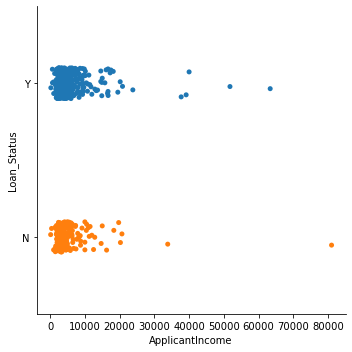

In [32]:
# TODO : Let's know the contribution of Applicant Income on determining Loan_Status 
sns.catplot(y = 'Loan_Status', x = 'ApplicantIncome', data = df)

###### From the above categorical plot, Applicant's income failed to differentiate Loan_Status. For more accuracy, we may drop the Applicant Income column.

<AxesSubplot:xlabel='ApplicantIncome', ylabel='Density'>

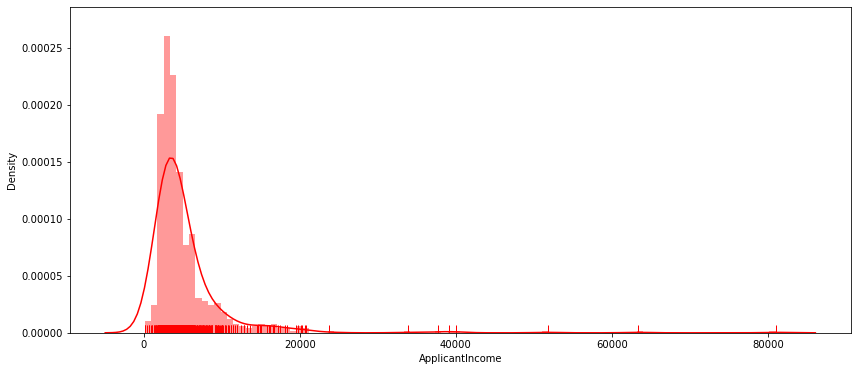

In [33]:
# TODO : Distribution of Applicant Income

plt.figure(figsize = (14, 6))
sns.distplot(df['ApplicantIncome'], rug = True, bins = 100, color='r')
# plt.savefig('../images/ApplicantIncomeDistribution.png')

- From the above distplot, most of the Applicants income less than Rs.10,000 and some considerable amount of applicants having income between Rs.10,000 and Rs.20,000.

<br><br><br>

#### 8. Co-applicant Income

In [34]:
df['CoapplicantIncome'].describe()

count      614.000000
mean      1621.245798
std       2926.248369
min          0.000000
25%          0.000000
50%       1188.500000
75%       2297.250000
max      41667.000000
Name: CoapplicantIncome, dtype: float64

In [35]:
df['CoapplicantIncome'].isnull().sum()

0

<AxesSubplot:xlabel='CoapplicantIncome', ylabel='Density'>

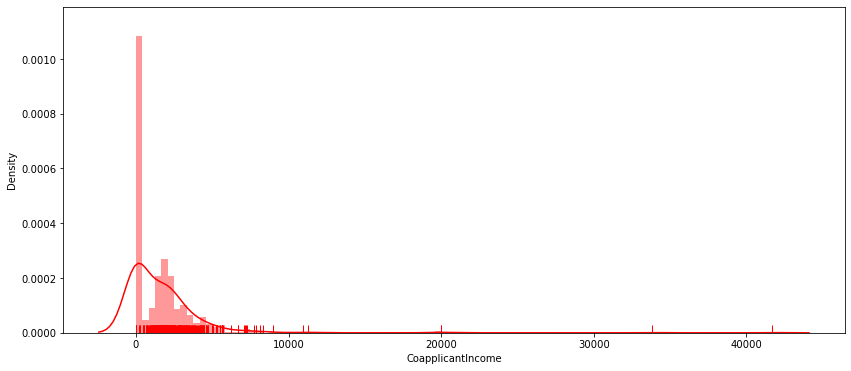

In [36]:
plt.figure(figsize = (14, 6))
sns.distplot(df['CoapplicantIncome'], rug = True, bins = 100, color='r')
# rug=True: When rug is set to True, small vertical lines ("rug plots") are drawn at each observation.
# bins=100: This sets the number of bins (intervals) for the histogram. In this case, it's set to 100.

<br><br><br>

#### 9. LoanAmount

In [37]:
# TODO : Descriptive Statistics on LoanAmount
df['LoanAmount'].describe()

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64

<AxesSubplot:xlabel='LoanAmount', ylabel='Density'>

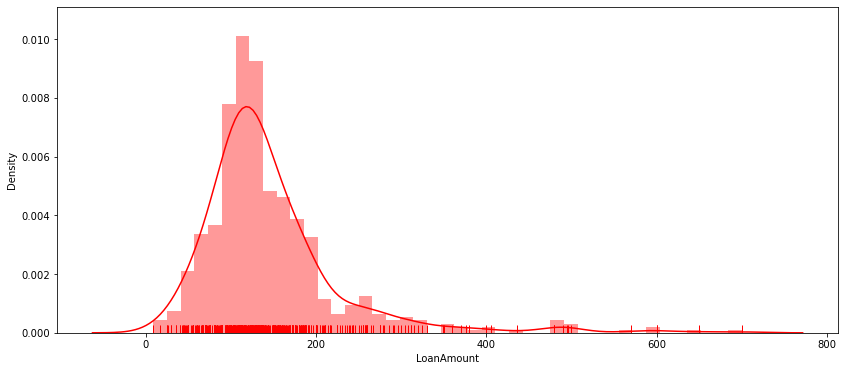

In [38]:
# TODO : Distribution of LoanAmount
plt.figure(figsize = (14, 6))
sns.distplot(df['LoanAmount'], rug = True, color = 'r')
# plt.savefig('../images/LoanAmountDistribution.png')

In [39]:
# TODO : Count of Null values on LoanAmount column
df['LoanAmount'].isnull().sum()

22

In [40]:
loan_yes_mean = np.mean(df[df['Loan_Status'] == 'Y']['LoanAmount'])
loan_no_mean = np.mean(df[df['Loan_Status'] == 'N']['LoanAmount'])
loan_no_mean

151.22099447513813

##### For yes in Loan_Status, average LoanAmount is 151.22 and no in Loan_Status, average LoanAmount is 144.29.

In [41]:
df.loc[df['Loan_Status'] == 'Y', 'LoanAmount'] = df.loc[df['Loan_Status'] == 'Y', 'LoanAmount'].fillna(loan_yes_mean)
df.loc[df['Loan_Status'] == 'N', 'LoanAmount'] = df.loc[df['Loan_Status'] == 'N', 'LoanAmount'].fillna(loan_no_mean)


<br><br><br>

#### 10. Loan_Amount_Term

In [42]:
df['Loan_Amount_Term'].describe()

count    600.00000
mean     342.00000
std       65.12041
min       12.00000
25%      360.00000
50%      360.00000
75%      360.00000
max      480.00000
Name: Loan_Amount_Term, dtype: float64

In [43]:
df['Loan_Amount_Term'].isnull().sum()

14

In [44]:
df['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

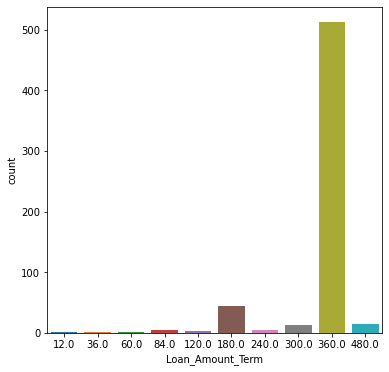

In [45]:
plt.figure(figsize=(6, 6))
sns.countplot(x = 'Loan_Amount_Term', data = df)
# plt.savefig('../images/term_counts.png')
plt.show()

##### Most of the applicants which is nearly 83 % of applicant chosen to Loan_Amount_Term of 360.

In [46]:
df[~df['Loan_Amount_Term'].isnull()].groupby('Loan_Status').describe().T.loc['Loan_Amount_Term']

Loan_Status,N,Y
count,186.000000,414.000000
mean,344.064516,341.072464
std,69.238921,63.247770
min,36.000000,12.000000
25%,360.000000,360.000000
50%,360.000000,360.000000
75%,360.000000,360.000000
max,480.000000,480.000000


##### For both status of Loan_Status, the average Loan_Amount_Term is approximately. Let's fill them with the value of 360.

In [47]:
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(value = 360)

<br><br><br>

##### 11. Credit_History

In [48]:
df['Credit_History'].describe()

count     564.0
unique      2.0
top         1.0
freq      475.0
Name: Credit_History, dtype: float64

In [49]:
df['Credit_History'].isnull().sum()

50

In [50]:
df['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

##### Since 78 % applicants having the Credit_History, we can fill the null values with 1.0

In [51]:
# TODO : Filling null values on Credit_History
df['Credit_History'] = df['Credit_History'].fillna(value = 1.0)

<br><br><br>

#### 12. Property_Area

In [52]:
df['Property_Area'].describe()

count           614
unique            3
top       Semiurban
freq            233
Name: Property_Area, dtype: object

In [53]:
df['Property_Area'].isnull().sum()

0

In [54]:
df['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

In [55]:
df['Property_Area'] = encode.fit_transform(df['Property_Area'])
df['Property_Area']

0      2
1      0
2      2
3      2
4      2
      ..
609    0
610    0
611    2
612    2
613    1
Name: Property_Area, Length: 614, dtype: int32

#### Finally we replaced all the null values with suitable values.

In [56]:
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

<br><br><br><br><br><br>

## Feature Selection

In [57]:
print(" Columns in the Train Data : \n", df.columns)

 Columns in the Train Data : 
 Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')


##### From the above discussion, we can remove some of the columns from the training data.

##### Those columns are Loan_ID

##### Let's drop the unwanted columns from train data

In [58]:
train_df = df.copy()

# TODO : Dropping Loan_ID column from the Train data
train_df.drop('Loan_ID', axis = 1, inplace = True)

# Detecting Outliers

In [59]:
train_df.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

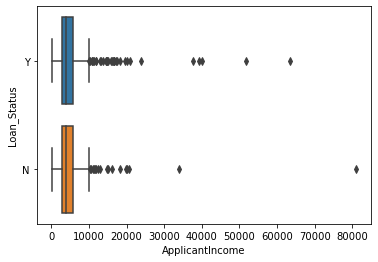

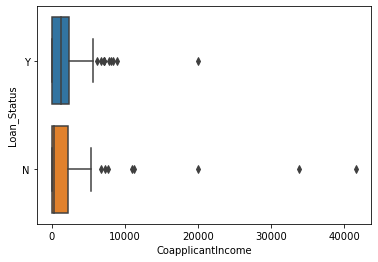

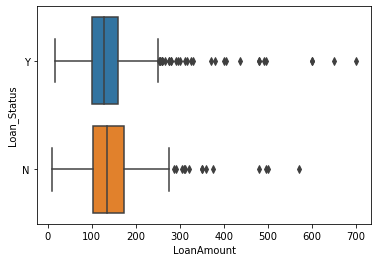

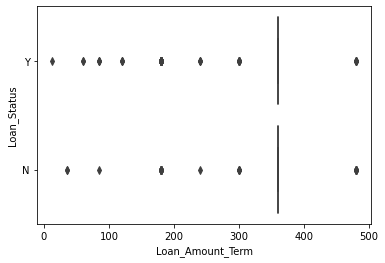

In [60]:
numerical_continuous_data_column = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
for column in numerical_continuous_data_column:
    sns.boxplot(x = column, y = 'Loan_Status', data = train_df)
    plt.show()

In [61]:
# TODO : Display samples having outliers on ApplicantIncome
train_df[train_df['ApplicantIncome'] > 25000]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
155,1,1,3,1,0,39999,0.0,600.0,180.0,0.0,1,Y
171,1,1,3,1,0,51763,0.0,700.0,300.0,1.0,2,Y
183,1,1,1,1,0,33846,0.0,260.0,360.0,1.0,1,N
185,1,1,0,1,1,39147,4750.0,120.0,360.0,1.0,1,Y
333,1,1,0,1,0,63337,0.0,490.0,180.0,1.0,2,Y
409,1,1,3,1,0,81000,0.0,360.0,360.0,0.0,0,N
443,1,0,1,1,0,37719,0.0,152.0,360.0,1.0,1,Y


#### Drop the samples having yes value on Loan_Status on  the above samples listed. Because of amount of Yes is a lot more than the No values.

In [62]:
samples_index_to_be_dropped = train_df[train_df['ApplicantIncome'] > 25000]
samples_index_to_be_dropped = samples_index_to_be_dropped[samples_index_to_be_dropped['Loan_Status'] == 'Y']
train_df.drop(index = samples_index_to_be_dropped.index, inplace = True)
train_df.reset_index(drop = True, inplace = True)

In [63]:
# TODO : Display samples having outliers on ApplicantIncome
train_df[train_df['CoapplicantIncome'] > 15000]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
398,1,0,0,1,0,2500,20000.0,103.0,360.0,1.0,1,Y
413,1,1,2,1,1,1600,20000.0,239.0,360.0,1.0,2,N
576,1,0,0,1,0,1836,33837.0,90.0,360.0,1.0,2,N
595,0,0,3,1,0,416,41667.0,350.0,180.0,1.0,2,N


#### Drop the samples having yes value on Loan_Status on  the above samples listed

In [64]:
samples_index_to_be_dropped = train_df[train_df['CoapplicantIncome'] > 25000]
samples_index_to_be_dropped = samples_index_to_be_dropped[samples_index_to_be_dropped['Loan_Status'] == 'Y']
train_df.drop(index = samples_index_to_be_dropped.index, inplace = True)
train_df.reset_index(drop = True, inplace = True)

In [65]:
# TODO : Display Samples having outliers on LoanAmount
train_df[train_df['LoanAmount'] > 400]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
130,1,0,0,1,1,20166,0.0,650.0,480.0,1.0,2,Y
175,1,1,3,1,0,5516,11300.0,495.0,360.0,0.0,1,N
275,1,1,0,1,0,14583,0.0,436.0,360.0,1.0,1,Y
305,1,0,0,1,0,20233,0.0,480.0,360.0,1.0,0,N
365,1,1,0,1,0,19730,5266.0,570.0,360.0,1.0,0,N
428,1,0,0,1,0,12876,0.0,405.0,360.0,1.0,1,Y
482,1,1,1,1,0,18333,0.0,500.0,360.0,1.0,2,N
501,1,1,0,1,0,20833,6667.0,480.0,360.0,1.0,2,Y
518,1,1,2,1,1,7948,7166.0,480.0,360.0,1.0,0,Y
556,0,1,1,1,1,19484,0.0,600.0,360.0,1.0,1,Y


#### Drop the samples having yes value on Loan_Status on  the above samples listed

In [66]:
samples_index_to_be_dropped = train_df[train_df['LoanAmount'] > 400]
samples_index_to_be_dropped = samples_index_to_be_dropped[samples_index_to_be_dropped['Loan_Status'] == 'Y']
train_df.drop(index = samples_index_to_be_dropped.index, inplace = True)
train_df.reset_index(drop = True, inplace = True)

<br><br><br><br><br><br><br>

# Feature Observation

In [67]:
loan_train_corr = train_df.corr()
loan_train_corr

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
Gender,1.000000,0.366590,0.187598,-0.050592,0.006503,0.041905,0.080830,0.145264,-0.074225,0.019670,-0.028539
Married,0.366590,1.000000,0.349393,-0.014614,0.002172,0.038114,0.071836,0.157251,-0.092243,0.012848,0.004311
Dependents,0.187598,0.349393,1.000000,-0.064881,0.063142,0.127664,0.031867,0.169228,-0.090352,-0.038471,0.005917
Education,-0.050592,-0.014614,-0.064881,1.000000,0.004306,0.134533,0.063269,0.159567,0.076501,0.072475,0.062972
Self_Employed,0.006503,0.002172,0.063142,0.004306,1.000000,0.141070,-0.025980,0.092210,-0.050635,-0.008373,-0.028762
ApplicantIncome,0.041905,0.038114,0.127664,0.134533,0.141070,1.000000,-0.135775,0.472939,0.009157,-0.030499,-0.068219
CoapplicantIncome,0.080830,0.071836,0.031867,0.063269,-0.025980,-0.135775,1.000000,0.253716,-0.064986,0.008903,0.014513
LoanAmount,0.145264,0.157251,0.169228,0.159567,0.092210,0.472939,0.253716,1.000000,0.065300,-0.010520,-0.096189
Loan_Amount_Term,-0.074225,-0.092243,-0.090352,0.076501,-0.050635,0.009157,-0.064986,0.065300,1.000000,-0.015778,-0.075664
Credit_History,0.019670,0.012848,-0.038471,0.072475,-0.008373,-0.030499,0.008903,-0.010520,-0.015778,1.000000,-0.000455


<AxesSubplot:>

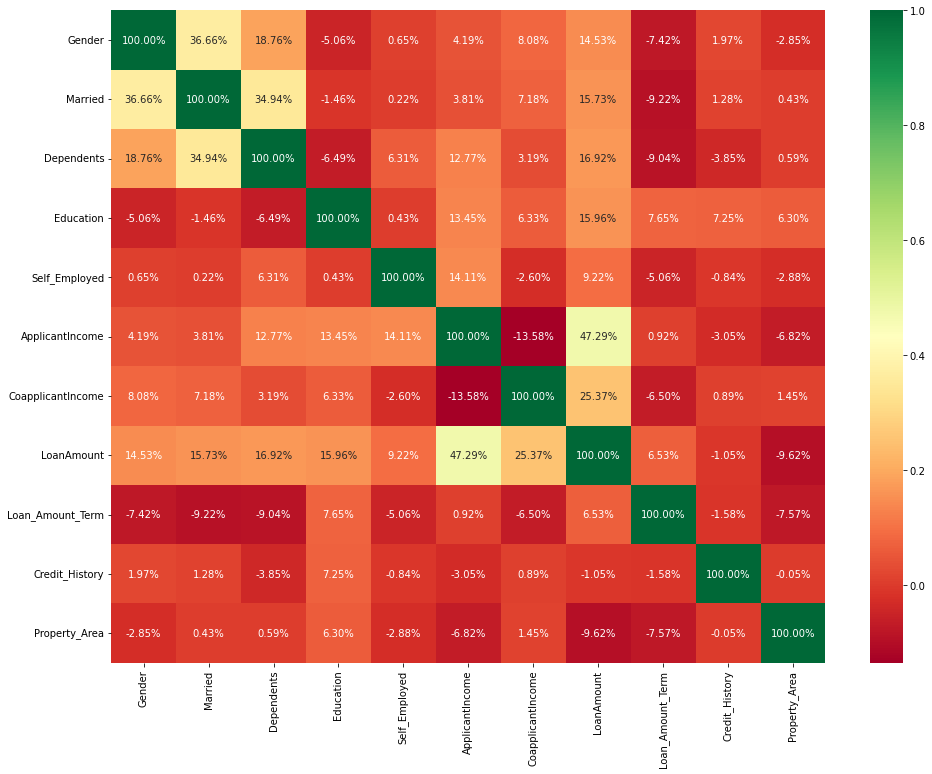

In [68]:
plt.figure(figsize = (16, 12))
sns.heatmap(loan_train_corr, cmap = 'RdYlGn', annot = True, fmt = '.2%')
# plt.savefig('../images/correlation_of_features.png')

In [69]:
train_df['Loan_Status'].value_counts()

Y    410
N    192
Name: Loan_Status, dtype: int64

#### We have to make the Training Data some more balanced

#### To make the data to be balanced, we are going to duplicate the samples having Loan_Status as NO

In [70]:
# TODO : Correlation of Features
corr_with_loan_status = train_df.corrwith(train_df['Loan_Status'].apply(lambda x : {'Y' : 1, 'N' : 0}[x]))
corr_with_loan_status.sort_values(ascending=False)

Credit_History       0.544114
Married              0.089913
Education            0.079361
Property_Area        0.028793
Gender               0.020874
Dependents           0.006241
Self_Employed       -0.011918
Loan_Amount_Term    -0.021419
CoapplicantIncome   -0.059633
ApplicantIncome     -0.073487
LoanAmount          -0.113612
dtype: float64

##### Credit_History is having more correlation with Loan_Status

<Figure size 864x432 with 0 Axes>

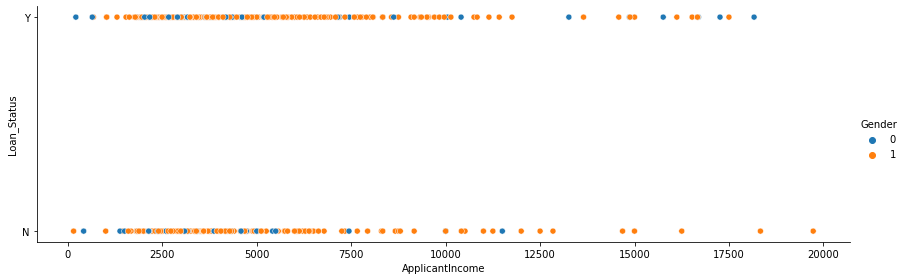

In [71]:
# TODO : Relation between Gender, Applicant Income and Loan Status
plt.figure(figsize = (12, 6))
sns.relplot(x = 'ApplicantIncome', y = 'Loan_Status', 
           data = train_df[train_df['ApplicantIncome'] <= 20000],
           hue = 'Gender', aspect = 3, height = 4)

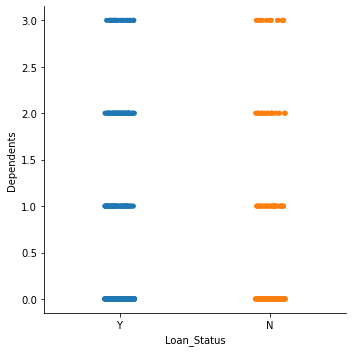

In [72]:
# Relation Between Dependents and Loan Status
sns.catplot(x = 'Loan_Status', y = 'Dependents', data = train_df)

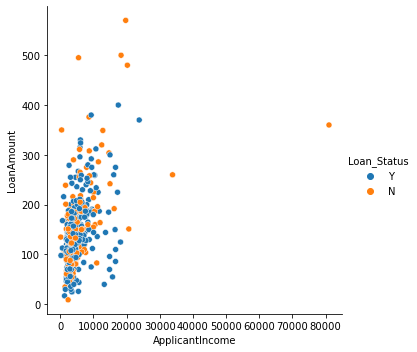

In [73]:
# Relation Between ApplicantIncome and LoanAmount with hue as Loan_Status
sns.relplot(x = 'ApplicantIncome', y = 'LoanAmount', data = train_df, hue = 'Loan_Status')

In [74]:
# TODO : To know the feature Importances
y = train_df['Loan_Status'].apply(lambda x : {'Y' : 1, 'N' : 0}[x]).values
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
etc.fit(train_df.iloc[:, :-1].values, y)

print("Percentage Importance of each features with respect to Loan_Status : ")
pd.Series(etc.feature_importances_*100, index = train_df.columns[:-1])

Percentage Importance of each features with respect to Loan_Status : 


Gender                1.943495
Married               1.873651
Dependents            5.880020
Education             1.963314
Self_Employed         2.172396
ApplicantIncome      18.157133
CoapplicantIncome    11.407340
LoanAmount           18.417961
Loan_Amount_Term      4.685402
Credit_History       28.619385
Property_Area         4.879903
dtype: float64

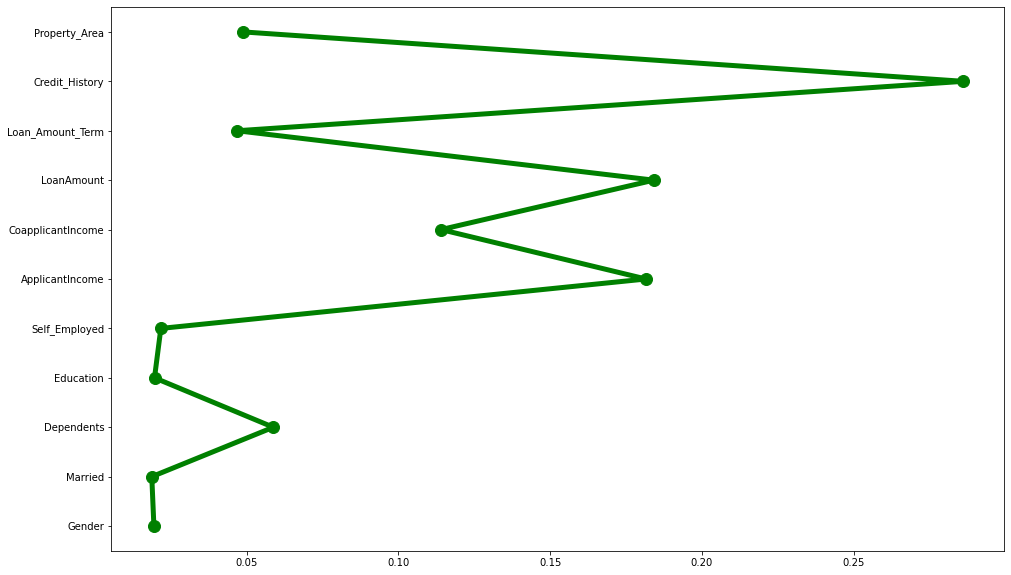

In [75]:
plt.figure(figsize=(16, 10))
plt.plot(etc.feature_importances_, train_df.columns[:-1], 'g-o', linewidth=5, markersize=12)

###### From the above plot, Credit_History (28 %) has the more importance, and then Loan Amount and Applicant Income and then Co-applicant Income

#### Relation Between Credit_History, Loan_Amount and Applicant_Income with Loan_Status

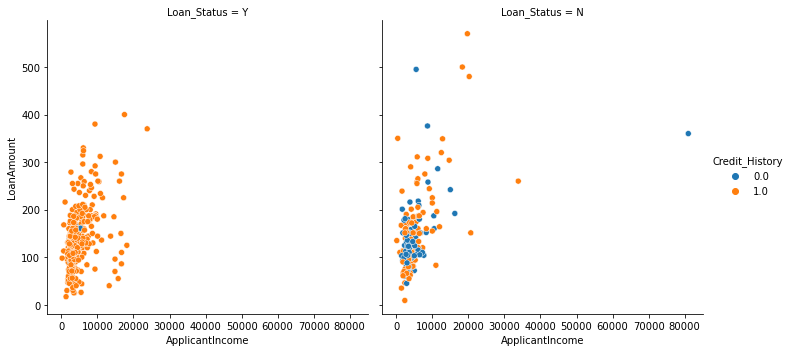

In [76]:
# TODO : Relation Between Credit_History, Loan_Amount and Applicant_Income with Loan_Status
sns.relplot(x = 'ApplicantIncome', y = 'LoanAmount', data = train_df,
           hue = 'Credit_History', col = 'Loan_Status')

From the above plot,
- The applicants those who are all having the credit history mostly getting te Loan Amount
- From this, Credit_History is the major feature.

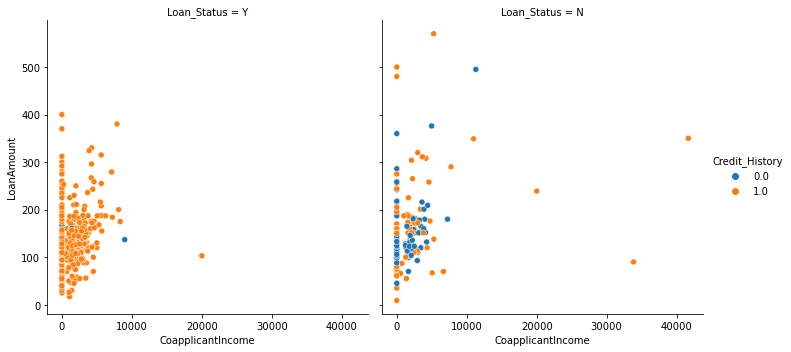

In [77]:
# TODO : Relation Between Credit_History, Loan_Amount and Coapplicant_Income with Loan_Status
sns.relplot(x = 'CoapplicantIncome', y = 'LoanAmount', data = train_df,
           hue = 'Credit_History', col = 'Loan_Status')

<br><br><br>

## Feature Selection

In [78]:
# TODO : Arranging features based on their importance to the Loan_Status
prediction_features = pd.Series(etc.feature_importances_*100, index = train_df.columns[:-1]).sort_values(ascending = False)

In [79]:
prediction_features = prediction_features.index

In [80]:
prediction_features = prediction_features[:5]
prediction_features

Index(['Credit_History', 'LoanAmount', 'ApplicantIncome', 'CoapplicantIncome',
       'Dependents'],
      dtype='object')

<br><br><br><br>

# Model Building

In [84]:
train_df['Loan_Status']  = encode.fit_transform(train_df['Loan_Status'])

In [85]:
feature_columns = train_df[prediction_features]
prediction_column = train_df['Loan_Status']

In [86]:
X = feature_columns.values
y = prediction_column.values

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)

In [89]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((481, 5), (121, 5), (481,), (121,))

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=1, random_state=42)
}

In [95]:
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, accuracy_score,classification_report,roc_auc_score

def loss(y_true, y_pred, retu=False):
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    loss = log_loss(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    
    if retu:
        return pre, rec, f1, loss, acc
    else:
        print('  pre: %.3f\n  rec: %.3f\n  f1: %.3f\n  loss: %.3f\n  acc: %.3f' % (pre, rec, f1, loss, acc))

In [96]:
def train_eval_train(models, X, y):
    for name, model in models.items():
        print(name,':')
        model.fit(X, y)
        loss(y, model.predict(X))
        print('-'*30)
        
train_eval_train(models, X_train, y_train)

LogisticRegression :
  pre: 0.791
  rec: 0.985
  f1: 0.877
  loss: 6.391
  acc: 0.815
------------------------------
KNeighborsClassifier :
  pre: 0.755
  rec: 0.895
  f1: 0.819
  loss: 9.191
  acc: 0.734
------------------------------
SVC :
  pre: 0.680
  rec: 1.000
  f1: 0.810
  loss: 10.915
  acc: 0.684
------------------------------
DecisionTreeClassifier :
  pre: 0.781
  rec: 0.985
  f1: 0.871
  loss: 6.750
  acc: 0.805
------------------------------


In [97]:
# train_eval_cross
# in the next cell i will be explaining this function

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

def train_eval_cross(models, X, y, folds):
    # we will change X & y to dataframe because we will use iloc (iloc don't work on numpy array)
    X = pd.DataFrame(X) 
    y = pd.DataFrame(y)
    idx = [' pre', ' rec', ' f1', ' loss', ' acc']
    for name, model in models.items():
        ls = []
        print(name,':')

        for train, test in folds.split(X, y):
            model.fit(X.iloc[train], y.iloc[train]) 
            y_pred = model.predict(X.iloc[test]) 
            ls.append(loss(y.iloc[test], y_pred, retu=True))
        print(pd.DataFrame(np.array(ls).mean(axis=0), index=idx)[0])  #[0] because we don't want to show the name of the column
        print('-'*30)
        
train_eval_cross(models, X_train, y_train, skf)

# ohhh, as i said SVC is just memorizing the data, and you can see that here DecisionTreeClassifier is better than LogisticRegression 

LogisticRegression :
 pre     0.790258
 rec     0.956635
 f1      0.865458
 loss    6.893055
 acc     0.800430
Name: 0, dtype: float64
------------------------------
KNeighborsClassifier :
 pre      0.692141
 rec      0.848221
 f1       0.762121
 loss    12.280904
 acc      0.644437
Name: 0, dtype: float64
------------------------------
SVC :
 pre      0.672975
 rec      0.993798
 f1       0.802487
 loss    11.345535
 acc      0.671521
Name: 0, dtype: float64
------------------------------
DecisionTreeClassifier :
 pre     0.781444
 rec     0.984567
 f1      0.871277
 loss    6.746930
 acc     0.804661
Name: 0, dtype: float64
------------------------------


In [101]:
from sklearn.model_selection import GridSearchCV
penalty = ['l1', 'l2']
C = np.logspace(-4,4,20)
#Menjadikan ke dalam bentuk dictionary
hyperparameters = dict(penalty=penalty, C=C)
#Membuat Object Logistic Regression
logreg = LogisticRegression()
#Memasukan ke Grid Search
#CV itu Cross Validation
#Menggunakan 10-Fold CV
standard_scaler = StandardScaler()

scaled_X_train = standard_scaler.fit_transform(X_train)
scaled_X_test = standard_scaler.transform(X_test)
clf = GridSearchCV(logreg, hyperparameters, cv=10)
#Fitting Model
best_model = clf.fit(scaled_X_train,y_train)
#Nilai hyperparameters terbaik
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
#Prediksi menggunakan model baru
y_pred = best_model.predict(scaled_X_test)
#Check performa dari model
print(classification_report(y_test, y_pred))
roc_auc_score(y_test, y_pred)

Best Penalty: l2
Best C: 0.615848211066026
              precision    recall  f1-score   support

           0       0.93      0.38      0.54        34
           1       0.80      0.99      0.89        87

    accuracy                           0.82       121
   macro avg       0.87      0.69      0.71       121
weighted avg       0.84      0.82      0.79       121



0.6854293441514536

<br><br><br><br>

## Decision Tree Classifier with Standard Scaling

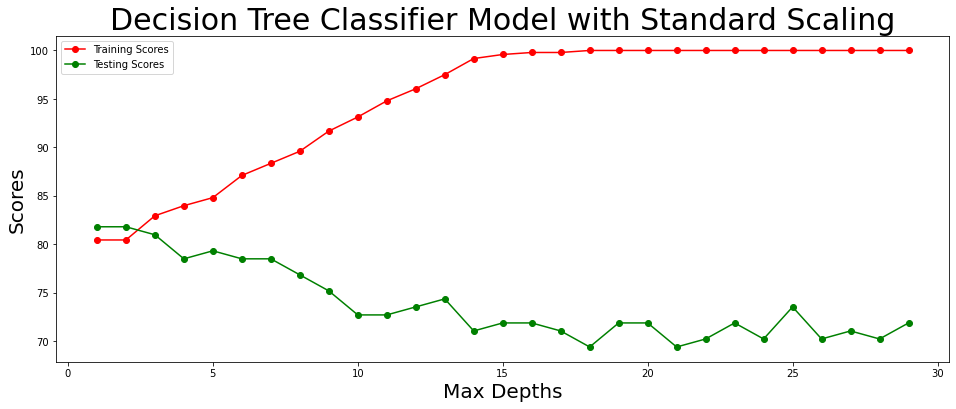

In [102]:
training_scores = []
testing_scores = []
max_depths = list(range(1, 30))
for max_depth in max_depths:
    # Converting Train Data to Same Scale
    standard_scaler = StandardScaler()
    
    scaled_X_train = standard_scaler.fit_transform(X_train)
    scaled_X_test = standard_scaler.transform(X_test)
    
    decision_tree_model = DecisionTreeClassifier(max_depth = max_depth)
    decision_tree_model.fit(scaled_X_train, y_train)
    training_scores.append(decision_tree_model.score(scaled_X_train, y_train) * 100)
    testing_scores.append(decision_tree_model.score(scaled_X_test, y_test) * 100)

plt.figure(figsize = (16, 6))
plt.plot(max_depths, training_scores, 'ro-')
plt.plot(max_depths, testing_scores, 'go-')
plt.xlabel('Max Depths', fontsize = 20)
plt.ylabel('Scores', fontsize = 20)
plt.title('Decision Tree Classifier Model with Standard Scaling', fontsize = 30)
# plt.ylim(50, 105)
plt.legend(labels = ['Training Scores', 'Testing Scores'])
plt.show()

In [103]:
# Let's print the corresponding Training and Testing Scores
for scores in zip(training_scores, testing_scores):
    print(scores)

(80.45738045738045, 81.81818181818183)
(80.45738045738045, 81.81818181818183)
(82.95218295218295, 80.99173553719008)
(83.991683991684, 78.51239669421489)
(84.82328482328482, 79.33884297520662)
(87.11018711018711, 78.51239669421489)
(88.35758835758836, 78.51239669421489)
(89.6049896049896, 76.85950413223141)
(91.68399168399168, 75.20661157024794)
(93.13929313929314, 72.72727272727273)
(94.8024948024948, 72.72727272727273)
(96.04989604989605, 73.55371900826447)
(97.5051975051975, 74.3801652892562)
(99.16839916839916, 71.07438016528926)
(99.58419958419958, 71.900826446281)
(99.7920997920998, 71.900826446281)
(99.7920997920998, 71.07438016528926)
(100.0, 69.42148760330579)
(100.0, 71.900826446281)
(100.0, 71.900826446281)
(100.0, 69.42148760330579)
(100.0, 70.24793388429752)
(100.0, 71.900826446281)
(100.0, 70.24793388429752)
(100.0, 73.55371900826447)
(100.0, 70.24793388429752)
(100.0, 71.07438016528926)
(100.0, 70.24793388429752)
(100.0, 71.900826446281)


In [104]:
from sklearn.pipeline import Pipeline
from sklearn import decomposition
std_slc = StandardScaler()
pca = decomposition.PCA()
dec_tree = DecisionTreeClassifier()

In [133]:
pipe = Pipeline(steps=[('std_slc', std_slc),
                        ('pca', pca),
                        ('dec_tree', dec_tree)])

In [141]:
X_train.shape[1]

5

In [134]:
n_components = list(range(1,X_train.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
parameters = dict(pca__n_components=n_components,
                    dec_tree__criterion=criterion,
                    dec_tree__max_depth=max_depth)

In [135]:
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('pca', PCA(n_components=4)),
                                       ('dec_tree', DecisionTreeClassifier())]),
             param_grid={'dec_tree__criterion': ['gini', 'entropy'],
                         'dec_tree__max_depth': [2, 4, 6, 8, 10, 12],
                         'pca__n_components': [1, 2, 3, 4, 5]})

In [136]:
print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_GS.best_estimator_.get_params()['dec_tree'])

Best Criterion: gini
Best max_depth: 2
Best Number Of Components: 4

DecisionTreeClassifier(max_depth=2)


In [147]:
standard_scaler = StandardScaler()
# Scaling training samples
scaled_X_train = standard_scaler.fit_transform(X_train)
# Scaling testing samples
scaled_X_test = standard_scaler.transform(X_test)

# PCA Implementation
pca = PCA(n_components = 5)
pca_X_train = pca.fit_transform(scaled_X_train)
pca_X_test = pca.transform(scaled_X_test)

In [148]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=2)

tree.fit(pca_X_train,y_train)
y_pred = tree.predict(pca_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.38      0.54        34
           1       0.80      0.99      0.89        87

    accuracy                           0.82       121
   macro avg       0.87      0.69      0.71       121
weighted avg       0.84      0.82      0.79       121



In [150]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(tree, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(pca_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.38      0.54        34
           1       0.80      0.99      0.89        87

    accuracy                           0.82       121
   macro avg       0.87      0.69      0.71       121
weighted avg       0.84      0.82      0.79       121

